In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple

import pickle

import sys
sys.path.append('../../')

from shipp.components import Storage
from aux_functions import extract_wind_data, extract_day_ahead_price, run_site_comparison, run_cost_comparison

# Input for site locations and data extraction with renewables ninja
filename_sites = 'sites2.csv'
# File containing the tokens - should be created by the user
token_rninja_file = 'token_rninja.txt'  
token_entsoe_file = 'token_entsoe.txt'

# Global input data for the numerical experiments
n = 364 * 24  # number of time steps
dt = 1 # time step duration [hour]
percent_bl = 0.99 # reliability of the baseload constraint
discount_rate = 0.03 #discount rate
n_year = 20  # Project duration [years]
bl_reference = 10 # Reference value for the baseload level
bl_vec = [6, 8, 10, 12] # Vector value for the comparison on baseload level

# Input data for the storage characteristics
p_cost1 = 150*1e3  # cost per power capacity for STS [USD/MW]
e_cost1_a = 75 * 1e3 # cost per energy capacity for STS - Advanced cost assumption [USD/MWh]
e_cost1_c = 175 * 1e3 # cost per energy capacity for STS - Conservative cost assumption [USD/MWh]
eta1 = 0.85 #Round trip efficiency for STS
lifetime1 = 10 # Lifetime for STS [years]

p_cost2 = 1500*1e3 # cost per power capacity for LTS [USD/MW]
e_cost2 = 5 * 1e3 # cost per energy capacity for LTS [USD/MWh]
eta2 = 0.50 #Round trip efficiency for LTS
lifetime2 = 20 # Lifetime for LTS [years]

# Sensitivity ranges
e_cost_range = np.array([50, 75, 100, 150, 175, 200, 250,300, 350])*1e3
p_cost_range = np.linspace(500, 7500, 8)*1e3

# e_cost_range = np.linspace(50, 350, 5)*1e3
# p_cost_range = np.linspace(500, 7500, 5)*1e3

# Solver for pyomo
pyo_solver = 'mosek'

# Parameters for loading/saving input data
load_saved_input_data = False
save_input_data = False
filename_input_data = 'input_data.pckl'

# Parameters for loading/saving optimization data for the site comparison
load_saved_opt_data_site = False
save_opt_data_site = False
filename_opt_data_site = 'data_site_comparison.pckl'

load_saved_opt_data_cost = False
save_opt_data_cost = False
filename_opt_data_cost = 'data_cost_comparison.pckl'




In [4]:
## Extract and post-process wind and price data
if load_saved_input_data:
    f = open(filename_input_data, 'rb')
    input_data = pickle.load(f)
    f.close()

    data_wind = input_data[0]
    power_wind = input_data[1]
    price = input_data[2]
else:
    # Retrieve token values from file
    with open(token_rninja_file, 'r') as file:
        token_rninja = file.read()

    with open(token_entsoe_file, 'r') as file:
        token_entsoe = file.read()

    # Extract Renewables.Ninja wind and power data
    data_wind, power_wind = extract_wind_data(filename_sites, token_rninja)
    # price = postprocess_price_data(filename_sites)
    
    # Retrieve ENTSO-E day-ahead market prices
    price = extract_day_ahead_price(filename_sites, token_entsoe)

    if save_input_data:
        input_data = [data_wind, power_wind, price]
        f = open(filename_input_data, 'wb')
        pickle.dump(input_data, f)
        f.close()

m = len(power_wind)
assert m >= len(price)
assert m >= len(data_wind)

if not load_saved_opt_data_site or not load_saved_opt_data_cost:
    time = 0
    print('Expected number of optimization to run:')
    if not load_saved_opt_data_site:
        print('\tSite comparison: ', m*2*len(bl_vec))
        time += 6.2*(m*2*len(bl_vec))
    if not load_saved_opt_data_cost:
        print('\tCost comparison: ', m*len(e_cost_range)*len(p_cost_range))
        time += 6.2*(m*len(e_cost_range)*len(p_cost_range))

    hours = np.floor(time / 3600)
    minutes = (time - hours*3600)/60
    print('Expected total time: {} h {:.1f} m'.format(hours, minutes))

30 data sets extracted succesfully from renewables.ninja.
Entso-e query: DE_LU 20190101 20200101
Entso-e query: DK_1 20190101 20200101
Entso-e query: DK_2 20190101 20200101
Entso-e query: NL 20190101 20200101
Expected number of optimization to run:
	Site comparison:  240
	Cost comparison:  2160
Expected total time: 4.0 h 8.0 m


In [43]:
# Building storage objects
stor_sts_a = Storage(e_cap = None, p_cap = None, eff_in =1, eff_out=eta1, e_cost = n_year/lifetime1*e_cost1_a, p_cost = n_year/lifetime1 *p_cost1)
stor_sts_c = Storage(e_cap = None, p_cap = None, eff_in =1, eff_out=eta1, e_cost = n_year/lifetime1 *e_cost1_c, p_cost = n_year/lifetime1 *p_cost1)
stor_lts = Storage(e_cap = None, p_cap = None, eff_in =1, eff_out=eta2, e_cost = n_year/lifetime2* e_cost2, p_cost = n_year/lifetime2*p_cost2)


In [44]:
# Numerical experiments for site comparison
if load_saved_opt_data_site:
    f = open(filename_opt_data_site, 'rb')
    data_site_comparison = pickle.load(f)
    f.close()

else:
    data_site_comparison = run_site_comparison(power_wind, price, n, dt, 
                                               percent_bl, discount_rate, 
                                               n_year, bl_vec, stor_sts_a, 
                                               stor_sts_c, stor_lts, pyo_solver)

    if save_opt_data_site:
        f = open(filename_opt_data_site, 'wb')
        pickle.dump(data_site_comparison, f)
        f.close()

# Load data from site comparison
p_st_vec = data_site_comparison[0]
npv_vec = data_site_comparison[1]
capex_vec = data_site_comparison[2]
rev_vec = data_site_comparison[3]
irr_vec = data_site_comparison[4]
increase_rev_vec = data_site_comparison[5]
os_vec = data_site_comparison[6]
p_range_vec = data_site_comparison[7]
mean_price2 = data_site_comparison[8]
corr_price_vec = data_site_comparison[9]
max_e_vec = data_site_comparison[10]
max_p_vec = data_site_comparison[11]
index_i = data_site_comparison[12]
wsp_vec = data_site_comparison[13]
sts_costs = data_site_comparison[14]
mean_p_vec = data_site_comparison[15]
bl_nrg_vec = data_site_comparison[16]


In [45]:
# Numerical experiments for cost comparison
if load_saved_opt_data_cost:
    f = open(filename_opt_data_cost, 'rb')
    data_cost_comparison = pickle.load(f)
    f.close()

else:
    data_cost_comparison = run_cost_comparison(power_wind, price, n, dt, 
                                               percent_bl, discount_rate, 
                                               n_year, bl_reference, stor_sts_a, 
                                               stor_lts, e_cost_range, 
                                               p_cost_range, pyo_solver)

    if save_opt_data_cost:
        f = open(filename_opt_data_cost, 'wb')
        pickle.dump(data_cost_comparison, f)
        f.close()

# Load data from cost comparison
e_cost_mat = data_cost_comparison[0]
p_cost_mat = data_cost_comparison[1]
a_npv_mat = data_cost_comparison[2]
p_st_mat = data_cost_comparison[3]
e_cap_lt_mat = data_cost_comparison[4]
p_cap_lt_mat = data_cost_comparison[5]
e_cap_st_mat = data_cost_comparison[6]
p_cap_st_mat = data_cost_comparison[7]
a_rev_mat = data_cost_comparison[8]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [46]:
# Graphic parameters for the plots

col_cy = "#00A6D6"
col_db = "#0C2340"
col_tu = "#00B8C8"
col_bl = "#0076C2"
col_pp = "#6F1D77"
col_pk = "#EF60A3"
col_dr = "#A50034"
col_rd = "#E03C31"
col_or = "#EC6842"
col_ye = "#FFB81C"
col_lg = "#6CC24A"
col_dg = "#009B77"

SMALL_SIZE = 5 +2 
MEDIUM_SIZE = 7+ 1 

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern']
mpl.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['hatch.color'] = 'grey'


save_fig = False
save_fig_folder = ''

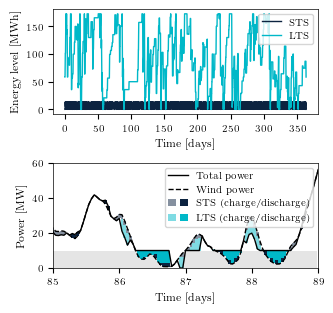

In [47]:
from aux_functions import get_p_min_vec
fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1)

fig.set_size_inches((8.5/2.54,8/2.54))

fig.subplots_adjust(hspace= 0.4)

idx = 2*m
os = os_vec[idx]
p_min_vec = get_p_min_vec(10, power_wind[0], percent_bl)

ax0.plot(os.storage_e[0].time()/24, os.storage_e[0].data, color = col_db, label = 'STS')
ax0.plot(os.storage_e[1].time()/24, os.storage_e[1].data, color = col_tu, label = 'LTS')
ax0.set_xlabel('Time [days]')
ax0.set_ylabel('Energy level [MWh]')
ax0.legend()

time_vec = os.power_out.time()/24
idx_wdw = np.arange((85*24),(89*24))
idx_wdw_plus = np.where(power_wind[0][idx_wdw] < os.power_out.data[idx_wdw])
idx_wdw_minus = np.where(power_wind[0][idx_wdw] >= os.power_out.data[idx_wdw])

line1 = ax1.plot(os.power_out.time()/24, os.power_out.data, 'k-', label = 'Total power')
line2 = ax1.plot(os.power_out.time()/24, power_wind[0][:n], 'k--', label = 'Wind power')
line3 = ax1.bar(time_vec[idx_wdw], p_min_vec[idx_wdw], alpha = 0.2, color = 'grey', width = 1/24, label = 'Baseload constraint')

sts1 = ax1.bar(time_vec[idx_wdw[idx_wdw_plus]], os.storage_p[0].data[idx_wdw[idx_wdw_plus]], 
                color = col_db, bottom = power_wind[0][idx_wdw[idx_wdw_plus]], width =  1/24, label = 'STS')
lts1 = ax1.bar(time_vec[idx_wdw[idx_wdw_plus]], os.storage_p[1].data[idx_wdw[idx_wdw_plus]], 
                color = col_tu, bottom = power_wind[0][idx_wdw[idx_wdw_plus]] + os.storage_p[0].data[idx_wdw[idx_wdw_plus]], width =  1/24, label = 'LTS')

sts2 = ax1.bar(time_vec[idx_wdw[idx_wdw_minus]], os.storage_p[0].data[idx_wdw[idx_wdw_minus]], 
                color = col_db, bottom = power_wind[0][idx_wdw[idx_wdw_minus]], width =  1/24, label = 'STS', alpha = 0.5)
lts2 = ax1.bar(time_vec[idx_wdw[idx_wdw_minus]], os.storage_p[1].data[idx_wdw[idx_wdw_minus]], 
                color = col_tu, bottom = power_wind[0][idx_wdw[idx_wdw_minus]] + os.storage_p[0].data[idx_wdw[idx_wdw_minus]], width =  1/24, label = 'LTS', alpha = 0.5)

ax1.set_xlim([85, 89])
ax1.set_ylim([0, 60])
ax1.legend(handles = [line1[0], line2[0], (sts2[0], sts1[0]), (lts2[0], lts1[0])], labels = ['Total power', 'Wind power', 'STS (charge/discharge)', 'LTS (charge/discharge)'], loc = 'upper right', handler_map={tuple: HandlerTuple(ndivide=None)})
ax1.set_xlabel('Time [days]')
ax1.set_xticks([85, 86, 87, 88, 89])
ax1.set_xticklabels(['85', '86', '87', '88', '89'])
ax1.set_ylabel('Power [MW]')

fig.tight_layout()
plt.show()

if save_fig:
    fig.savefig(save_fig_folder+'example_case.png', dpi = 800, bbox_inches='tight')

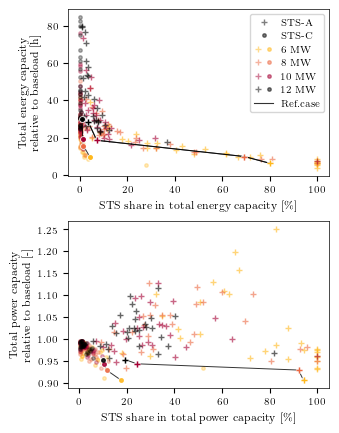

In [48]:
col_vec = [col_ye, col_or, col_dr, 'black']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# fig.set_size_inches((17.9/2.54+1,6/2.54+1))
fig.subplots_adjust(wspace=0.4)
fig.set_size_inches((8.5/2.54,8.5/2.54+1))


plus_mrk = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
                          alpha = 0.5, label='STS-A')
point_mrk = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                          alpha = 0.5, label='STS-C')
mrk_6 = mlines.Line2D([], [], color=col_vec[0], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 6 MW')
mrk_6p = mlines.Line2D([], [], color=col_vec[0], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 6 MW')
mrk_8 = mlines.Line2D([], [], color=col_vec[1], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 8 MW')
mrk_10 = mlines.Line2D([], [], color=col_vec[2], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 10 MW')
mrk_12 = mlines.Line2D([], [], color=col_vec[3], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 12 MW')

mrk_8p= mlines.Line2D([], [], color=col_vec[1], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 8 MW')
mrk_10p = mlines.Line2D([], [], color=col_vec[2], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 10 MW')
mrk_12p = mlines.Line2D([], [], color=col_vec[3], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 12 MW')

ref_case_idx_a = [0, m, 2*m, 3*m]
ref_case_idx_c = [4*m, 5*m, 6*m, 7*m]

for i in range(8*m):
    if i<4*m:
        mrk = '+'
        alpha_tmp = 0.6
        if i%m == 0:
        #     ref_case_idx_a.append(i)
            # mrk = '*'
            alpha_tmp = 1.0
    else:
        mrk = '.'
        alpha_tmp = 0.3
        if i%m == 0:
        #     ref_case_idx_c.append(i)
            alpha_tmp = 1.0
            # mrk = 'd'

    if p_range_vec[i] == 6:
        col_tmp = col_vec[0]
    elif p_range_vec[i] == 8:
        col_tmp = col_vec[1]
    elif p_range_vec[i] == 10:
        col_tmp = col_vec[2]
    else:
        col_tmp = col_vec[3]

    ax1.plot( 100*os_vec[i].storage_list[0].e_cap/(os_vec[i].storage_list[0].e_cap + os_vec[i].storage_list[1].e_cap),
            (os_vec[i].storage_list[0].e_cap + os_vec[i].storage_list[1].e_cap)/p_range_vec[i], 
            mrk, color = col_tmp, alpha=alpha_tmp)
    
    ax2.plot( 100*os_vec[i].storage_list[0].p_cap/(os_vec[i].storage_list[0].p_cap + os_vec[i].storage_list[1].p_cap),
            (os_vec[i].storage_list[0].p_cap + os_vec[i].storage_list[1].p_cap)/p_range_vec[i], 
            mrk, color = col_tmp, alpha=alpha_tmp)


tmp_x_a = np.zeros((4,))
tmp_y_a = np.zeros((4,))
tmp_x_c = np.zeros((4,))
tmp_y_c = np.zeros((4,))

for k in range(len(ref_case_idx_a)):
    tmp_x_a[k] = (100*os_vec[ref_case_idx_a[k]].storage_list[0].e_cap/(os_vec[ref_case_idx_a[k]].storage_list[0].e_cap + os_vec[ref_case_idx_a[k]].storage_list[1].e_cap))
    tmp_y_a[k] = ((os_vec[ref_case_idx_a[k]].storage_list[0].e_cap + os_vec[ref_case_idx_a[k]].storage_list[1].e_cap)/p_range_vec[ref_case_idx_a[k]])
for k in range(len(ref_case_idx_c)):
    tmp_x_c[k] = (100*os_vec[ref_case_idx_c[k]].storage_list[0].e_cap/(os_vec[ref_case_idx_c[k]].storage_list[0].e_cap + os_vec[ref_case_idx_c[k]].storage_list[1].e_cap))
    tmp_y_c[k] = ((os_vec[ref_case_idx_c[k]].storage_list[0].e_cap + os_vec[ref_case_idx_c[k]].storage_list[1].e_cap)/p_range_vec[ref_case_idx_c[k]])


ref_case_line = ax1.plot( tmp_x_a, tmp_y_a, '-', color = 'black', markeredgecolor = 'none', markerfacecolor = 'white', alpha=0.8, linewidth = 0.8)
ax1.plot( tmp_x_a, tmp_y_a, 'o-', color = 'black', markeredgecolor = 'none', markerfacecolor = 'white', alpha=0.8, linewidth = 0.7)
ax1.plot( tmp_x_c, tmp_y_c, 'o-', color = 'black', markeredgecolor = 'none', markerfacecolor = 'white', alpha=0.8, linewidth = 0.7)

for k in range(len(ref_case_idx_a)):
    ax1.plot( tmp_x_a[k], tmp_y_a[k], '+', color = col_vec[k], alpha=1.0)
for k in range(len(ref_case_idx_c)):
    ax1.plot( tmp_x_c[k], tmp_y_c[k], '.', color = col_vec[k], alpha=1.0)

for k in range(len(ref_case_idx_a)):
    tmp_x_a[k] = (100*os_vec[ref_case_idx_a[k]].storage_list[0].p_cap/(os_vec[ref_case_idx_a[k]].storage_list[0].p_cap + os_vec[ref_case_idx_a[k]].storage_list[1].p_cap))
    tmp_y_a[k] = ((os_vec[ref_case_idx_a[k]].storage_list[0].p_cap + os_vec[ref_case_idx_a[k]].storage_list[1].p_cap)/p_range_vec[ref_case_idx_a[k]])
for k in range(len(ref_case_idx_c)):    
    tmp_x_c[k] = (100*os_vec[ref_case_idx_c[k]].storage_list[0].p_cap/(os_vec[ref_case_idx_c[k]].storage_list[0].p_cap + os_vec[ref_case_idx_c[k]].storage_list[1].p_cap))
    tmp_y_c[k] = ((os_vec[ref_case_idx_c[k]].storage_list[0].p_cap + os_vec[ref_case_idx_c[k]].storage_list[1].p_cap)/p_range_vec[ref_case_idx_c[k]])


ax2.plot( tmp_x_a, tmp_y_a, 'o-', color = 'black', markeredgecolor = 'none', markerfacecolor = 'white', alpha=0.8, linewidth = 0.7)
ax2.plot( tmp_x_c, tmp_y_c, 'o-', color = 'black', markeredgecolor = 'none', markerfacecolor = 'white', alpha=0.8, linewidth = 0.7)

for k in range(len(ref_case_idx_a)):
    ax2.plot( tmp_x_a[k], tmp_y_a[k], '+', color = col_vec[k], alpha=1.0)
    ax2.plot( tmp_x_c[k], tmp_y_c[k], '.', color = col_vec[k], alpha=0.8)



ax1.set_ylabel('Total energy capacity\n relative to baseload [h]')
ax1.set_xlabel(r'STS share in total energy capacity [\%]')

ax2.set_ylabel('Total power  capacity\n relative to baseload [-]')
ax2.set_xlabel(r'STS share in total power capacity [\%]')

ax1.legend([plus_mrk, point_mrk, (mrk_6p,mrk_6), (mrk_8p, mrk_8), (mrk_10p, mrk_10), (mrk_12p, mrk_12), ref_case_line[0]], ['STS-A', 'STS-C', '6 MW', '8 MW', '10 MW', '12 MW', 'Ref.case'], handler_map={tuple: HandlerTuple(ndivide=None)})

# ax3.set_xlabel('Storage CAPEX [M.USD]')
# ax3.set_ylabel('NPV [M.USD]')
# # ax1.legend()
ax2.set_ylim([0.88735666361066, 1.2684443975000215])
ax2.set_xlim([-4.8387501906823855, 104.99232143765055])
# print(ax2.get_xlim())
fig.tight_layout()
plt.show()

if save_fig:
    fig.savefig(save_fig_folder+'sizing_analysis.png', dpi = 800, bbox_inches='tight')

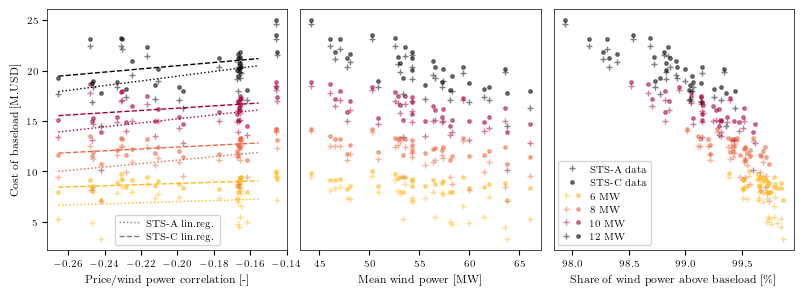

In [49]:
share_nrg_vec = [] 
share_nrg_vec_above = [] 

for k in [0, 1]:
    for p_min in [6, 8, 10, 12]:
        for i in range(m):
            tmp_vec = [ (p) if p<= p_min else 0 for p in power_wind[i][:n]]
            share_nrg_vec.append(100*sum([ (p) if p<= p_min else 0 for p in power_wind[i][:n]])/sum(power_wind[i][:n]))
            share_nrg_vec_above.append(100*sum([ 0 if p<= p_min else p for p in power_wind[i][:n]])/sum(power_wind[i][:n]))

share_nrg_vec = np.array(share_nrg_vec)
share_nrg_vec_above = np.array(share_nrg_vec_above)

markers_vec = ['o', 's', '<', '>', 'v', '^', 'd', 'p', 'X', 'P']


# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
#                                     figsize=(17.9/2.54,6/2.54))
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3)
# fig.set_size_inches((17.9/2.54,6/2.54))
fig.set_size_inches((17.9/2.54+1,5/2.54+1))


fig.subplots_adjust(wspace=0.2)

# max_e_vec = np.array(max_e_vec)
# max_e_vec_norm = np.array(max_e_vec)/p_range_vec

cnt = 0

# for i in range(len(corr_price_vec)):
    # ax1.plot(mean_price2[i], npv_vec[i],  'ko', alpha = 0.2)
    # ax2.plot(corr_price_vec[i], increase_rev_vec[i], 'ko', alpha = 0.2)
    # ax3.plot(bl_nrg_vec[i], npv_vec[i], 'ko', alpha = 0.2)
    # # ax4.plot(p_range_vec[i], npv_vec[i], 'ko', alpha = 0.2)
    
    # ax4.plot(max_e_vec[i], npv_vec[i], 'ko', alpha = 0.2)


for p_min in [6, 8, 10, 12]:
    mrk = '.'
    bool_vec = np.logical_and(p_range_vec==p_min, sts_costs == sts_costs.max())
    y_data = -npv_vec[np.where(bool_vec)]


    x_data = [ corr_price_vec[np.where(bool_vec)], mean_p_vec[np.where(bool_vec)] , share_nrg_vec_above[np.where(bool_vec)]]
    # ax2.plot(x_data[0], y_data, 'o', alpha = 0.5, color = col_vec[(p_min-6)//2])
    # ax3.plot(x_data[1], y_data,'o', alpha = 0.5, color = col_vec[(p_min-6)//2])
    # ax4.plot(x_data[2], y_data,'o', alpha = 0.5, color = col_vec[(p_min-6)//2])

    for ax, x_data_tmp in zip([ax2,ax3, ax4], x_data):
        ax.plot(x_data_tmp, y_data, mrk, alpha = 0.5, color = col_vec[(p_min-6)//2])

        if ax == ax2:
            lin_reg = np.poly1d(np.polyfit(x_data_tmp,y_data,1)) 
            x = np.arange(min(x_data_tmp), max(x_data_tmp), 0.01)
            ax.plot(x, lin_reg(x), '--', color = col_vec[(p_min-6)//2])

    mrk = '+'
    bool_vec = np.logical_and(p_range_vec==p_min, sts_costs == sts_costs.min())
    y_data = -npv_vec[np.where(bool_vec)]


    x_data = [ corr_price_vec[np.where(bool_vec)], mean_p_vec[np.where(bool_vec)] , share_nrg_vec_above[np.where(bool_vec)]]
    # ax2.plot(x_data[0], y_data, 'o', alpha = 0.5, color = col_vec[(p_min-6)//2])
    # ax3.plot(x_data[1], y_data,'o', alpha = 0.5, color = col_vec[(p_min-6)//2])
    # ax4.plot(x_data[2], y_data,'o', alpha = 0.5, color = col_vec[(p_min-6)//2])

    for ax, x_data_tmp in zip([ax2,ax3, ax4], x_data):
        ax.plot(x_data_tmp, y_data, mrk, alpha = 0.5, color = col_vec[(p_min-6)//2])
        if ax == ax2:
            lin_reg = np.poly1d(np.polyfit(x_data_tmp,y_data,1)) 
            x = np.arange(min(x_data_tmp), max(x_data_tmp), 0.01)
            ax.plot(x, lin_reg(x), ':', color = col_vec[(p_min-6)//2])

ax2.set_xlabel('Price/wind power correlation [-]')

ax3.set_xlabel('Mean wind power [MW]')

ax4.set_xlabel(r'Share of wind power above baseload [\%]')

ax2.set_ylabel('Cost of baseload [M.USD]')
for ax in [ax3, ax4]:
    ax.set_yticks([])

# delta = 0.05

# for ax in [ax2, ax3, ax4]:
#     pos = ax.get_position()
#     ax.set_position([pos.x0, pos.y0,pos.x1-pos.x0, pos.y1-pos.y0-delta])

plus_mrk = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
                          alpha = 0.5, label='STS-A')
point_mrk = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                          alpha = 0.5, label='STS-C')

dotted_ln = mlines.Line2D([], [], color='black', linestyle=':', alpha = 0.5)
dashed_ln = mlines.Line2D([], [], color='black', linestyle='--', alpha = 0.5)

mrk_6 = mlines.Line2D([], [], color=col_vec[0], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 6 MW')
mrk_6p = mlines.Line2D([], [], color=col_vec[0], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 6 MW')
mrk_8 = mlines.Line2D([], [], color=col_vec[1], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 8 MW')
mrk_10 = mlines.Line2D([], [], color=col_vec[2], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 10 MW')
mrk_12 = mlines.Line2D([], [], color=col_vec[3], marker='.', linestyle='None',
                          alpha = 0.5, label=r' 12 MW')

mrk_8p= mlines.Line2D([], [], color=col_vec[1], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 8 MW')
mrk_10p = mlines.Line2D([], [], color=col_vec[2], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 10 MW')
mrk_12p = mlines.Line2D([], [], color=col_vec[3], marker='+', linestyle='None',
                          alpha = 0.5, label=r' 12 MW')

# ax4.legend([plus_mrk, dotted_ln,  point_mrk, dashed_ln,  (mrk_6p,mrk_6), (mrk_8p, mrk_8), 
#             (mrk_10p, mrk_10), (mrk_12p, mrk_12)], 
#             ['STS-A data', 'STS-A lin.reg.', 'STS-C data', 'STS-C lin.reg.', '6 MW', '8 MW', '10 MW', '12 MW'], 
#             handler_map={tuple: HandlerTuple(ndivide=None)})
ax2.legend([ dotted_ln,   dashed_ln], 
            ['STS-A lin.reg.',  'STS-C lin.reg.'], 
            handler_map={tuple: HandlerTuple(ndivide=None)})
ax4.legend([plus_mrk,   point_mrk,   (mrk_6p,mrk_6), (mrk_8p, mrk_8), 
            (mrk_10p, mrk_10), (mrk_12p, mrk_12)], 
            ['STS-A data', 'STS-C data', '6 MW', '8 MW', '10 MW', '12 MW'], 
            handler_map={tuple: HandlerTuple(ndivide=None)})

fig.tight_layout()
plt.show()

# fig.savefig('figures/sites_comparison2_ppt.png', dpi = 800, bbox_inches='tight')
# print(np.array(fig.get_size_inches())*2.54)

if save_fig:    
    fig.savefig(save_fig_folder+'site_comparison_a_c.png', dpi = 800, bbox_inches='tight')

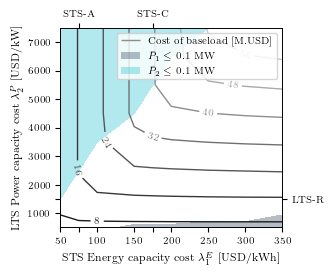

In [50]:
idx = 0

fig, (ax) = plt.subplots(nrows= 1, ncols = 1)
# fig.subplots_adjust(bottom=0.2)

fig_width = 8.5
fig_height = 7

fig.set_size_inches((fig_width/2.54,(fig_height)/2.54))

CS2a = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_st_mat[idx], levels = [-1, 0.1], 
                colors = col_db, alpha = 0.3) #, hatches=['\\\\']

CS2b = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_lt_mat[idx], levels = [-1, 0.1], colors = col_tu, alpha = 0.3)

CS1 = ax.contour(e_cost_mat/1e3, p_cost_mat/1e3, -a_npv_mat[idx], cmap = 'gray')
ax.clabel(CS1, inline=True, fontsize=SMALL_SIZE)



h1,_ = CS1.legend_elements()
h2,_ = CS2a.legend_elements()
h2b,_ = CS2b.legend_elements()
ax.legend([h1[5], h2[0], h2b[0]], 
        ['Cost of baseload [M.USD]', r'$\bar{P}_1 \leq$ 0.1 MW', r'$\bar{P}_2 \leq$ 0.1 MW'])


ax.set_xlabel(r'STS Energy capacity cost $\lambda^E_1$ [USD/kWh]')
ax.set_ylabel(r'LTS Power capacity cost $\lambda^P_2$ [USD/kW]')



ax.set_yticks([1000, 1500, 2000,3000,4000,5000,6000,7000])
ax.set_yticklabels(['1000', '', '2000', '3000', '4000', '5000', '6000', '7000'])

ax.set_xticks([50,75,100,150,175,200,250,300,350])
ax.set_xticklabels(['50','','100','150','','200','250','300','350'])


ylim = ax.get_ylim()
xlim = ax.get_xlim()

newax = ax.twiny()
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.xaxis.set_ticks_position('top')
newax.xaxis.set_label_position('top')
newax.set_xlim([xlim[0], xlim[1]])
newax.set_xticks([75, 175])
newax.set_xticklabels(['STS-A', 'STS-C'])

neway = ax.twinx()
neway.set_frame_on(True)
neway.patch.set_visible(False)
neway.yaxis.set_ticks_position('right')
neway.yaxis.set_label_position('right')
neway.set_ylim([ylim[0], ylim[1]])
neway.set_yticks([1500])
neway.set_yticklabels(['LTS-R'])

fig.tight_layout()
plt.show()

if save_fig:
        fig.savefig(save_fig_folder+'contour_plot_costs.png', dpi = 800, bbox_inches='tight')

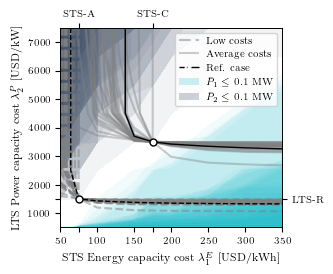

In [51]:
fig, (ax) = plt.subplots(nrows= 1, ncols = 1)
# fig.subplots_adjust(bottom=0.2)
fig_width = 8.5
fig_height = 7

fig.set_size_inches((fig_width/2.54,(fig_height)/2.54))

idx_i = 1
idx_j = 1

for idx in range(len(a_npv_mat)):
    CS2a = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_st_mat[idx], levels = [-1, 0.1],
                colors = col_tu, alpha = 0.05)
    CS2b = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_lt_mat[idx], levels = [-1, 0.1], colors = col_db, alpha = 0.05)

    CS2c = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_lt_mat[idx], levels = [-1, -0.5], colors = col_tu, alpha = 0.2)
    CS2d = ax.contourf(e_cost_mat/1e3, p_cost_mat/1e3, p_cap_lt_mat[idx], levels = [-1, -0.5], colors = col_db, alpha = 0.2)

    value_contour = -a_npv_mat[idx][idx_i][idx_j]
    CS1 = ax.contour(e_cost_mat/1e3, p_cost_mat/1e3, -a_npv_mat[idx], levels = [value_contour], alpha = 0.5, linestyles = 'dashed',colors = 'grey', linewidths = [1.5])

    value_contour = -a_npv_mat[idx][idx_i+2][idx_j+3]
    CS3 = ax.contour(e_cost_mat/1e3, p_cost_mat/1e3, -a_npv_mat[idx], levels = [value_contour], alpha = 0.4, linestyles = 'solid',colors = 'grey', linewidths = [1.5])

idx = 0
value_contour = -a_npv_mat[idx][idx_i][idx_j]
CS10 = ax.contour(e_cost_mat/1e3, p_cost_mat/1e3, -a_npv_mat[idx], levels = [value_contour], alpha = 1.0, linestyles = 'dashed',colors = 'black', linewidths = [1])

value_contour = -a_npv_mat[idx][idx_i+2][idx_j+3]
CS30 = ax.contour(e_cost_mat/1e3, p_cost_mat/1e3, -a_npv_mat[idx], levels = [value_contour], alpha = 1.0, linestyles = 'solid',colors = 'black', linewidths = [1])


ax.plot(e_cost_mat[idx_i]/1e3, p_cost_mat[idx_j]/1e3, 'o', markerfacecolor='white', markeredgecolor='black')
ax.plot(e_cost_mat[idx_i+3]/1e3, p_cost_mat[idx_j+2]/1e3, 'o', markerfacecolor='white', markeredgecolor='black')

ax.set_xlabel(r'STS Energy capacity cost $\lambda^E_1$ [USD/kWh]')
ax.set_ylabel(r'LTS Power capacity cost $\lambda^P_2$ [USD/kW]')


ax.set_yticks([1000, 1500, 2000,3000,4000,5000,6000,7000])
ax.set_yticklabels(['1000', '', '2000', '3000', '4000', '5000', '6000', '7000'])

ax.set_xticks([50,75,100,150,175,200,250,300,350])
ax.set_xticklabels(['50','','100','150','','200','250','300','350'])


ylim = ax.get_ylim()
xlim = ax.get_xlim()

newax = ax.twiny()
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.xaxis.set_ticks_position('top')
newax.xaxis.set_label_position('top')
newax.set_xlim([xlim[0], xlim[1]])
newax.set_xticks([75, 175])
newax.set_xticklabels(['STS-A', 'STS-C'])

neway = ax.twinx()
neway.set_frame_on(True)
neway.patch.set_visible(False)
neway.yaxis.set_ticks_position('right')
neway.yaxis.set_label_position('right')
neway.set_ylim([ylim[0], ylim[1]])
neway.set_yticks([1500])
neway.set_yticklabels(['LTS-R'])


h1,_ = CS1.legend_elements()
h3,_ = CS3.legend_elements()
h10,_ = CS10.legend_elements()
h30,_ = CS30.legend_elements()
h2c,_ = CS2c.legend_elements()
h2d,_ = CS2d.legend_elements()
ax.legend([h1[0], h3[0], (h10[0], h30[0]), h2c[0], h2d[0]], 
        ['Low costs', 'Average costs', 'Ref. case', r'$\bar{P}_1 \leq$ 0.1 MW', r'$\bar{P}_2 \leq $ 0.1 MW'], handler_map={tuple: HandlerTuple(ndivide=None)})

fig.tight_layout()
plt.show()

if save_fig:
    fig.savefig(save_fig_folder+'contour_plot_costs_all.png', dpi = 800, bbox_inches='tight')

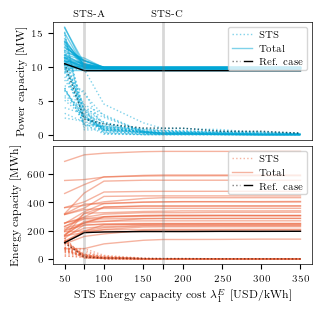

In [52]:

fig, (ax0, ax1) = plt.subplots(nrows= 2, ncols = 1)
# fig.subplots_adjust(top=0.2)
# fig.subplots_adjust(hspace=0.05)
fig_width = 8.5
fig_height = 8
fig.set_size_inches((fig_width/2.54,(fig_height)/2.54))
fig.subplots_adjust(hspace = 0.05)
idx_i = 1

for idx in range(len(a_npv_mat)):
    
    tot_p_cap = 1+0*(np.array(p_cap_lt_mat[idx][idx_i][-1]) + np.array(p_cap_st_mat[idx][idx_i][-1]))
    tot_e_cap = 1+0*(np.array(e_cap_lt_mat[idx][idx_i][-1]) + np.array(e_cap_st_mat[idx][idx_i][-1]))

    l1 = ax0.plot(e_cost_mat*1e-3, np.array(p_cap_st_mat[idx][idx_i])/tot_p_cap, ':', 
                  alpha = 0.5, color = col_cy, fillstyle = 'none', label = 'STS')
    l2 = ax0.plot(e_cost_mat*1e-3, (np.array(p_cap_lt_mat[idx][idx_i]) + np.array(p_cap_st_mat[idx][idx_i]))/tot_p_cap, '-', alpha = 0.5, color = col_cy, fillstyle = 'full', label = 'Total')

    l3 = ax1.plot(e_cost_mat*1e-3, e_cap_st_mat[idx][idx_i]/tot_e_cap, ':', alpha = 0.5, color = col_or, fillstyle = 'none', label = 'STS')
    l4 = ax1.plot(e_cost_mat*1e-3, (np.array(e_cap_lt_mat[idx][idx_i]) + np.array(e_cap_st_mat[idx][idx_i]))/tot_e_cap, '-', alpha = 0.5, color = col_or, fillstyle = 'full', label = 'Total')

    ax1.set_ylabel('Energy capacity [MWh]')
    ax1.set_xlabel(r'STS Energy capacity cost $\lambda_1^E$ [USD/kWh]')
    ax0.set_xticks([])
    ax0.set_ylabel('Power capacity [MW]')
    

idx = 0
tot_p_cap = 1+0*(np.array(p_cap_lt_mat[idx][idx_i][-1]) + np.array(p_cap_st_mat[idx][idx_i][-1]))
tot_e_cap = 1+0*(np.array(e_cap_lt_mat[idx][idx_i][-1]) + np.array(e_cap_st_mat[idx][idx_i][-1]))

l10 = ax0.plot(e_cost_mat*1e-3, np.array(p_cap_st_mat[idx][idx_i])/tot_p_cap, ':', 
                alpha = 0.5, color = 'black', fillstyle = 'none', label = 'STS')
l20 = ax0.plot(e_cost_mat*1e-3, (np.array(p_cap_lt_mat[idx][idx_i]) + np.array(p_cap_st_mat[idx][idx_i]))/tot_p_cap, '-', alpha = 1.0, color = 'black', fillstyle = 'full', label = 'Total')

l30 = ax1.plot(e_cost_mat*1e-3, e_cap_st_mat[idx][idx_i]/tot_e_cap, ':', alpha = 0.5, color = 'black', fillstyle = 'none', label = 'STS')
l40 = ax1.plot(e_cost_mat*1e-3, (np.array(e_cap_lt_mat[idx][idx_i]) + np.array(e_cap_st_mat[idx][idx_i]))/tot_e_cap, '-', alpha = 1.0, color = 'black', fillstyle = 'full', label = 'Total')

ylim0 = ax0.get_ylim()
ylim1 = ax1.get_ylim()

ax0.plot([75,75], [ylim0[0]-1, ylim0[1]+1], '-', linewidth = 2, color = 'grey', alpha = 0.3)
ax0.plot([175,175], [ylim0[0]-1, ylim0[1]+1], '-', linewidth = 2, color = 'grey', alpha = 0.3)
ax1.plot([75,75], [ylim1[0]-1, ylim1[1]+1], '-', linewidth = 2, color = 'grey', alpha = 0.3)
ax1.plot([175,175], [ylim1[0]-1, ylim1[1]+1], '-', linewidth = 2, color = 'grey', alpha = 0.3)

ax0.set_ylim(ylim0)
ax1.set_ylim(ylim1)

trans = ax0.get_xaxis_transform() # x in data untis, y in axes fraction
ann = ax0.annotate('STS-A', xy=(75-15, 1.05 ), xycoords=trans)
ann = ax0.annotate('STS-C', xy=(175-15, 1.05 ), xycoords=trans)

ax1.set_xticks([50,75,100,150,175,200,250,300,350])
ax1.set_xticklabels(['50','','100','150','','200','250','300','350'])


leg0 = ax0.legend(handles = [l1[0], l2[0], (l10[0], l20[0])], labels = ['STS', 'Total', 'Ref. case'], loc ='best', handler_map={tuple: HandlerTuple(ndivide=None)})
leg1 = ax1.legend(handles = [l3[0], l4[0], (l30[0], l40[0])], labels = ['STS', 'Total', 'Ref. case'], loc ='best', handler_map={tuple: HandlerTuple(ndivide=None)})

# fig.tight_layout()
plt.show()

if save_fig:
    fig.savefig(save_fig_folder+'e_and_p_capacity_costs_all.png', dpi = 800, bbox_inches='tight')